Initialising particles...
Diffusing particles...
Computing SS...
Inverting SS...
Computing meanZ
Done
Initialising particles...
Particle shape:
(30, 24000, 3)
Diffusing particles...


c:\users\nur izfarwiza\documents\dissertation\advectiongp\advectionGP\models\mfmodels.py:173: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)


cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 60, 20, 20)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 60, 20, 20)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 60, 20, 20)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 60, 20, 20)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 60, 20, 20)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 60, 20, 20)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 60, 20, 20)
Computing Source from Phi...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 60, 20, 20)
Computing Source from Phi...
cache mi

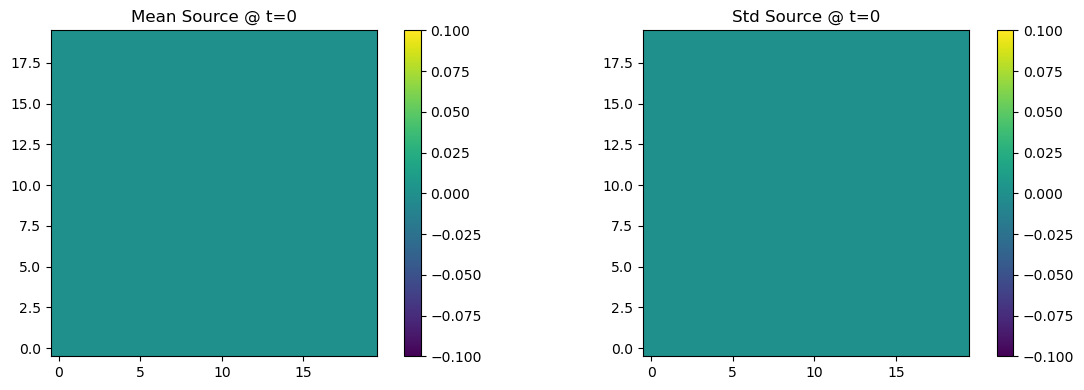

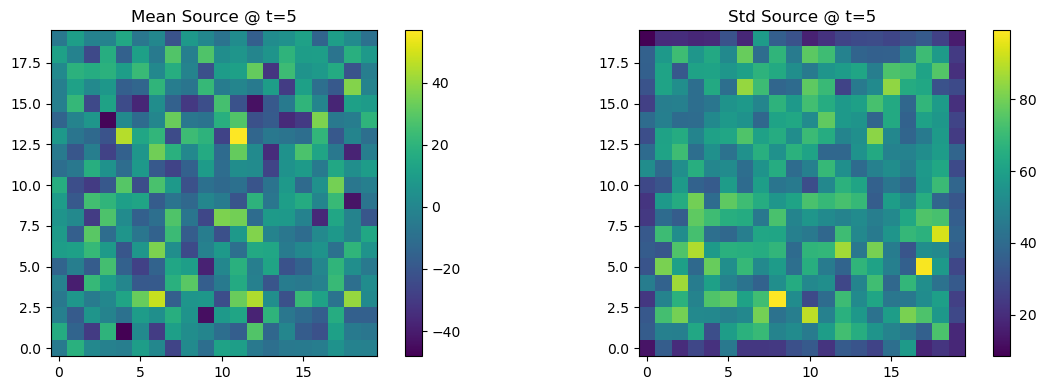

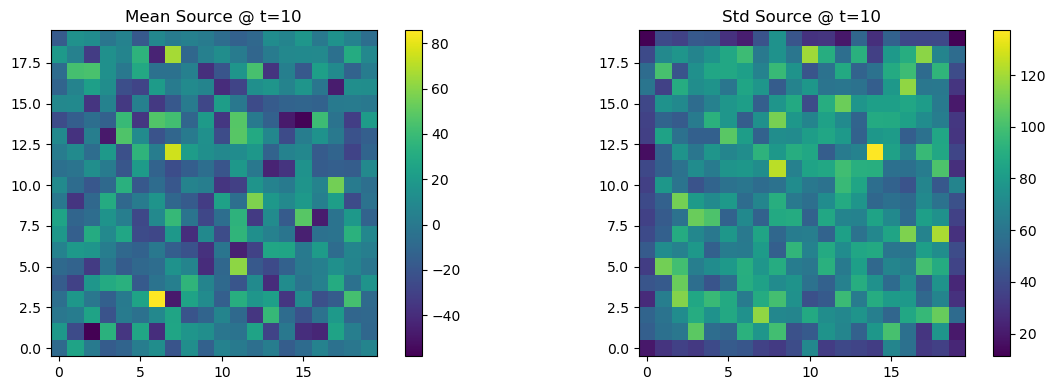

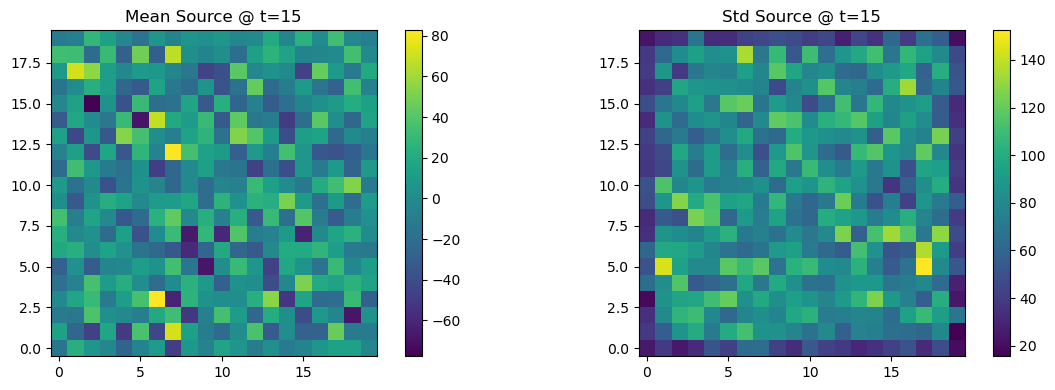

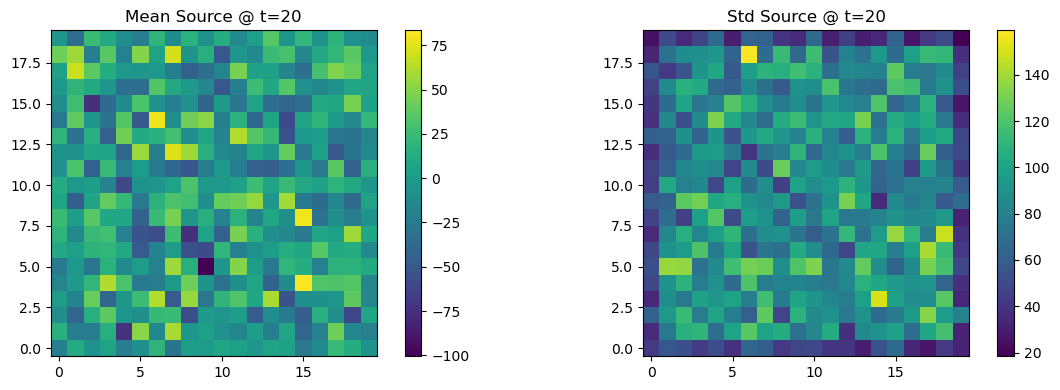

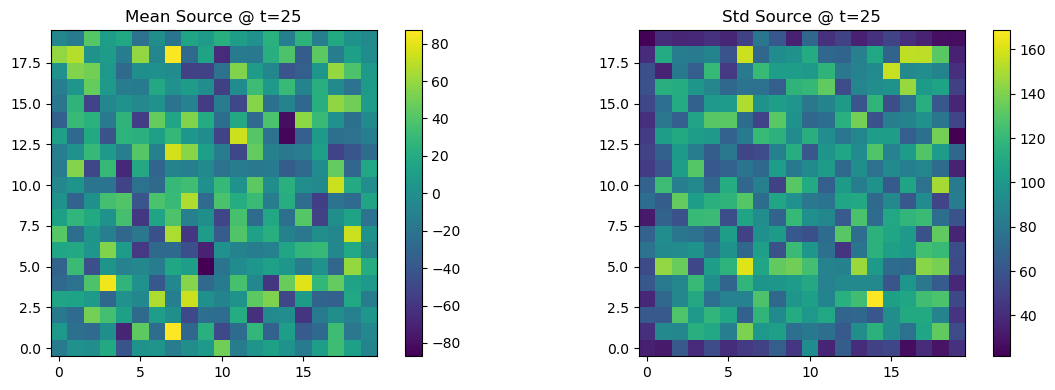

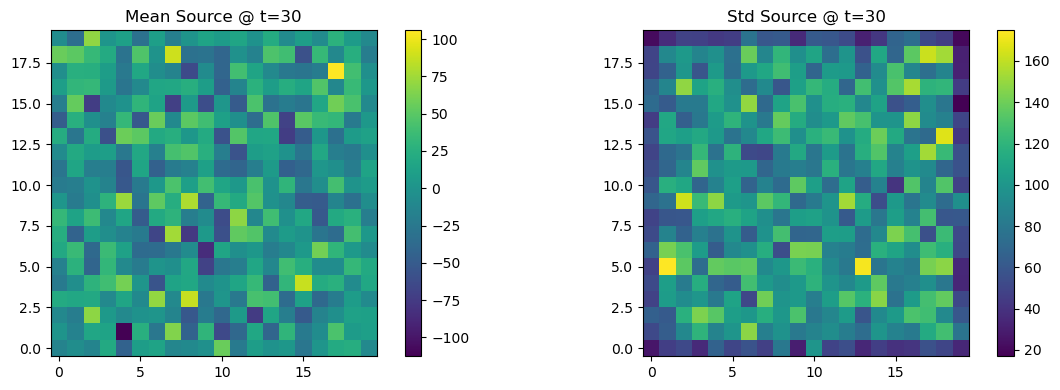

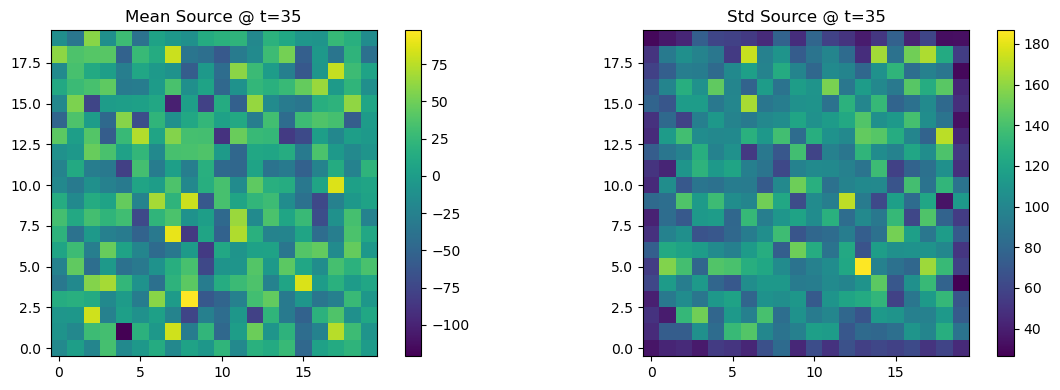

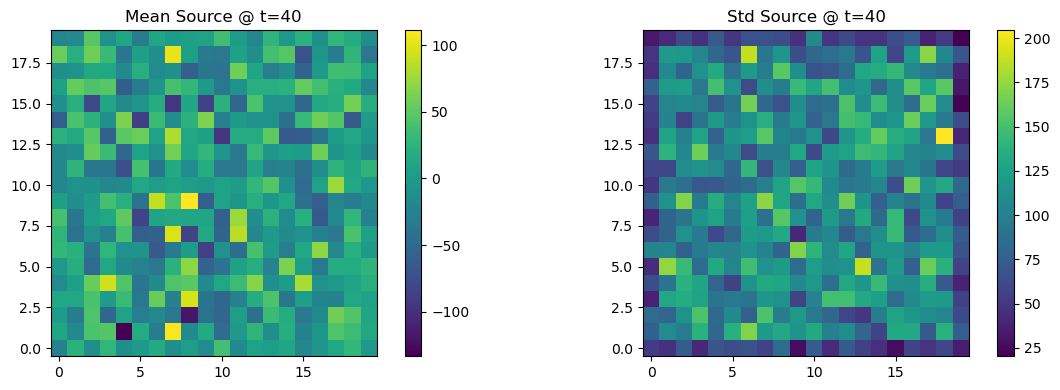

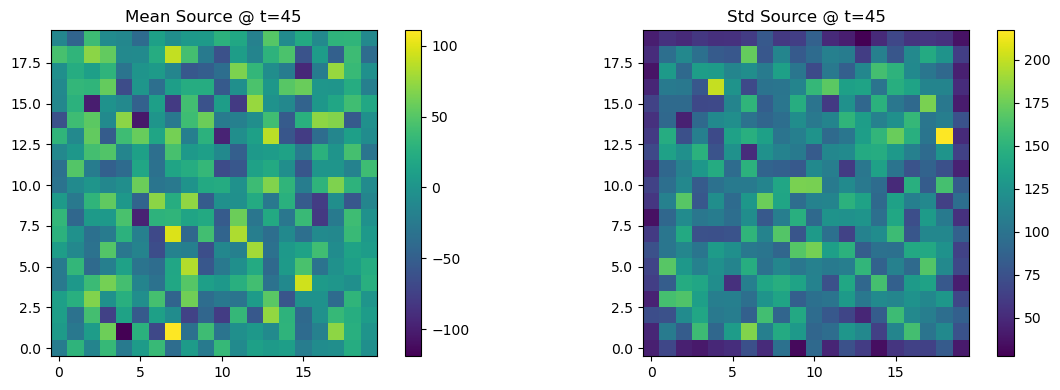

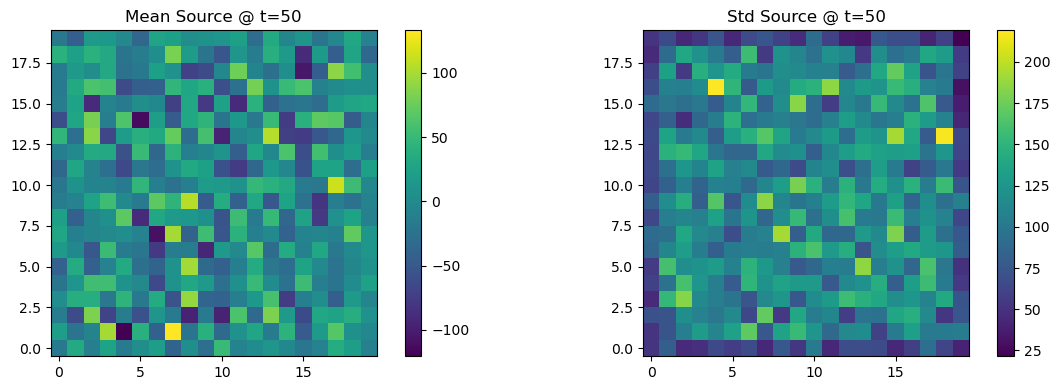

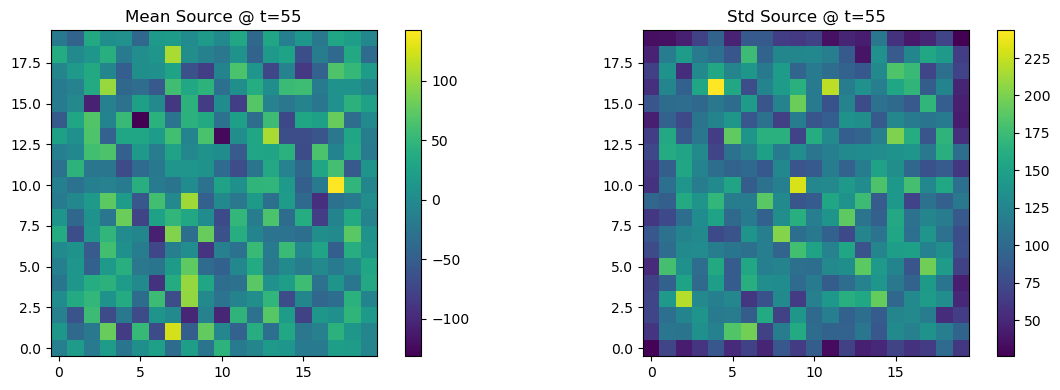

In [23]:
from pyproj import Proj
import numpy as np
from scipy.stats import norm
from advectionGP.kernels import EQ
from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.wind import WindSimple
from advectionGP.sensors import RemoteSensingModel
from advectionGPdatasets import proposeboundary
import matplotlib.pyplot as plt

# === Step 1: Define UTM and Spatial Domain ===
proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
xmin, ymin = proj(146, -38)
xmax, ymax = proj(148, -36)

# === Step 2: Define Observation-Like Bounding Box ===
# Use fake obsLocs just for proposeboundary
dummy_obsLocs = np.array([[0, 1440, x, y] for x in np.linspace(xmin, xmax, 5) for y in np.linspace(ymin, ymax, 10)])
boundary = proposeboundary(dummy_obsLocs)
padding = 50_000
boundary = (
    np.array(boundary[0]),
    np.array(boundary[1])
)
boundary[0][1:] -= padding
boundary[1][1:] += padding

# === Step 1: Setup UTM Projection ===
proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
# Convert lat/lon bounding box of Victoria to UTM
xmin, ymin = proj(146, -38)
xmax, ymax = proj(148, -36)

# === Step 2: Generate Observation Locations ===
# Create evenly spaced 5 x-centers and 10 y-centers in UTM space
x_centers = np.linspace(xmin, xmax, 5)
y_centers = np.linspace(ymin, ymax, 10)

# Set time range for each observation (last 3 hours of the day)
t_start, t_end = 1260, 1440

# Generate obsLocs as [t_start, t_end, x, y] combinations (shape = 50, 4)
obsLocs = np.array([[t_start, t_end, x, y] for x in x_centers for y in y_centers])


# === Step 3: Sensor Model (no longer needs getHs) ===
sensors = RemoteSensingModel( simulation_minutes=1440, dt=180)

# === Step 4: Setup Kernel & Wind ===
N_feat = 1000
k = EQ(10, 1)
res = [60, 20, 20]
noiseSD = 0.001
k_0 = 0.05
windmodel = WindSimple(0, 0)

# === Step 5: Initialize Mesh-Free Model ===
mInfer = Model(
    resolution=res,
    boundary=boundary,
    N_feat=N_feat,
    noiseSD=noiseSD,
    kernel=k,
    sensormodel=sensors,
    windmodel=windmodel,
    k_0=k_0
)

# === Step 6: Generate Regressor Matrix ===
mInfer.computeModelRegressors()
num_obs = mInfer.X.shape[1]

# === Step 7: Generate Synthetic Observations ===
def generate_Y_from_obsLocs(obsLocs, centre_x, centre_y, D=2e7):
    Y = []
    for t_start, t_end, x, y in obsLocs:
        t = (t_start + t_end) / 2.0
        d = np.linalg.norm([x - centre_x, y - centre_y])
        
        # Clip blobsize to avoid extreme values
        blobsize = np.sqrt(2 * 2 * D * (t + 4))
        blobsize = np.clip(blobsize, 1, 1e6)
        
        try:
            spatial = norm(0, blobsize).pdf(d)
            temporal = norm(600, 300).cdf(t)  # Change from norm(10,1) to something meaningful
            v = 1000 * spatial * temporal / blobsize
        except:
            v = 0.0  # fallback if anything breaks
        
        if not np.isfinite(v):  # guard against nan/inf
            v = 0.0
        Y.append(v)
    
    return np.array(Y)


centre_x = (xmin + xmax) / 2
centre_y = (ymin + ymax) / 2
Y = generate_Y_from_obsLocs(obsLocs[:num_obs], centre_x, centre_y, D=2e7)
Y = Y.reshape(-1)
Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))
# === Step 8: Inference ===
meanZ, covZ = mInfer.computeZDistribution(Y)

# === Step 9: Grid Setup for Visualization ===
t_vals = np.linspace(boundary[0][0], boundary[1][0], res[0])
x_vals = np.linspace(boundary[0][1], boundary[1][1], res[1])
y_vals = np.linspace(boundary[0][2], boundary[1][2], res[2])
coords = np.stack(np.meshgrid(t_vals, x_vals, y_vals, indexing='ij'), axis=-1)
coords = coords.reshape(-1, 3)

# === Step 10: Forward Simulation ===
sourcemean, sourcevar, all_samples = mInfer.computeConcentration(
    meanZ=meanZ,
    covZ=covZ,
    Nsamps=10,
    Nparticles=30,
    coords=coords,
    interpolateSource=True
)

# === Step 11: Plotting ===
sourcemean = sourcemean.reshape(res)
sourcevar = sourcevar.reshape(res)

for t_index in range(0, res[0], 5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Mean Source @ t={t_index}")
    plt.imshow(sourcemean[t_index], origin='lower')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title(f"Std Source @ t={t_index}")
    plt.imshow(np.sqrt(sourcevar[t_index]), origin='lower')
    plt.colorbar()
    plt.tight_layout()
    plt.show()


In [5]:
particles = mInfer.genParticlesFromObservations(Nparticles=10)
print("Particle bounds:", np.min(particles), np.max(particles))


Particle bounds: -594384.2495157844 5934001.534353418


In [24]:
print("Y shape:", Y.shape)
print("Y min:", np.min(Y))
print("Y max:", np.max(Y))
print("Y mean:", np.mean(Y))
print("Y has NaN:", np.isnan(Y).any())
print("Y[:5]:", Y[:5])


Y shape: (50,)
Y min: 0.0
Y max: 1.0
Y mean: 0.5588320881176025
Y has NaN: False
Y[:5]: [0.         0.25755198 0.45496025 0.58862483 0.65608255]


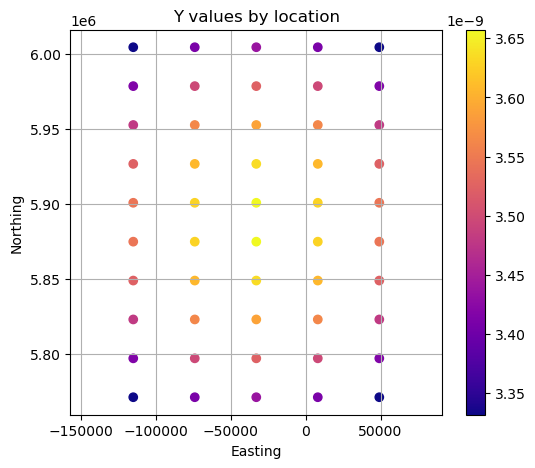

In [22]:
import matplotlib.pyplot as plt

x_vals = obsLocs[:, 2]
y_vals = obsLocs[:, 3]

plt.figure(figsize=(6, 5))
sc = plt.scatter(x_vals, y_vals, c=Y, cmap="plasma")
plt.colorbar(sc)
plt.title("Y values by location")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.axis("equal")
plt.grid(True)
plt.show()


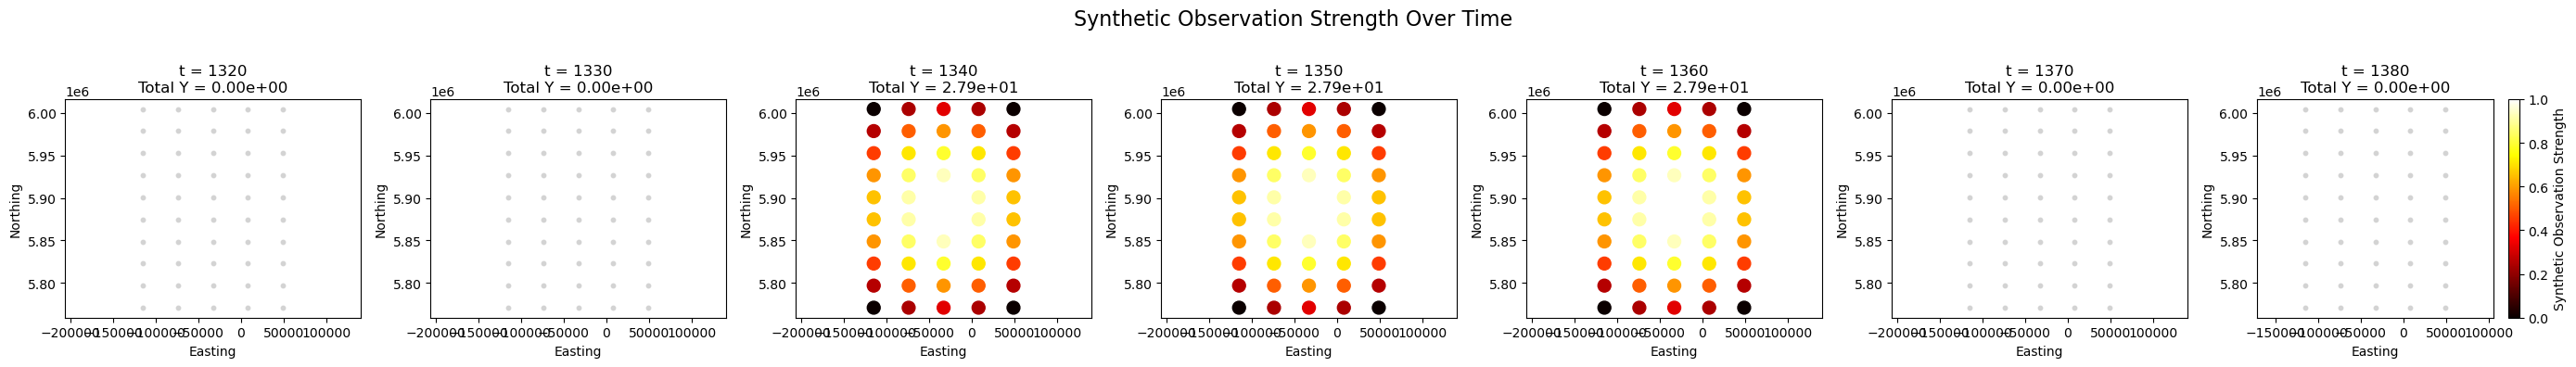

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Use midpoint time for each observation
obsTimes = (obsLocs[:num_obs, 0] + obsLocs[:num_obs, 1]) / 2
xs = obsLocs[:num_obs, 2]
ys = obsLocs[:num_obs, 3]

# Define time bins to visualize
time_bins = np.arange(1320, 1381, 10)# every 30 minutes
n_plots = len(time_bins)

plt.figure(figsize=(4 * n_plots, 4))
for i, t in enumerate(time_bins):
    plt.subplot(1, n_plots, i + 1)
    
    # Filter observations near this time
    keep = np.abs(obsTimes - t) < 15  # ±15 minutes window
    
    plt.scatter(xs, ys, color='lightgrey', s=10, label='All Sensors')
    sc = plt.scatter(xs[keep], ys[keep], c=Y[keep], cmap='hot', s=100)
    
    plt.title(f"t = {t:.0f}\nTotal Y = {np.sum(Y[keep]):.2e}")
    plt.xlabel("Easting")
    plt.ylabel("Northing")
    plt.axis('equal')

plt.colorbar(sc, label='Synthetic Observation Strength')
plt.suptitle("Synthetic Observation Strength Over Time", fontsize=16)
plt.tight_layout()
plt.show()


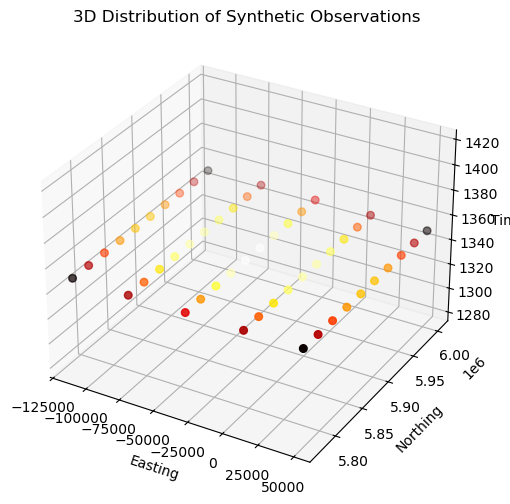

In [26]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, obsTimes, c=Y, cmap='hot', s=30)
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ax.set_zlabel("Time")
plt.title("3D Distribution of Synthetic Observations")
plt.show()


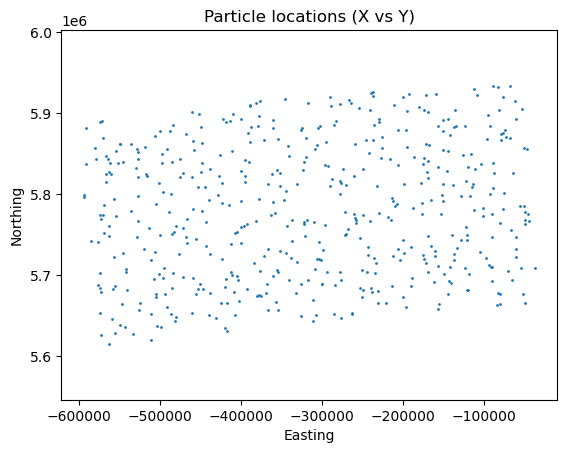

In [6]:
import matplotlib.pyplot as plt
plt.scatter(particles[...,1].flatten(), particles[...,2].flatten(), s=1)
plt.title("Particle locations (X vs Y)")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.axis("equal")
plt.show()


In [19]:
print("X shape:", mInfer.X.shape)
print("X min:", np.min(mInfer.X))
print("X max:", np.max(mInfer.X))
print("X mean:", np.mean(mInfer.X))
print("X has NaN:", np.isnan(mInfer.X).any())
print("Y min:", Y.min(), "Y max:", Y.max(), "Y mean:", Y.mean())
print("Y has NaN:", np.isnan(Y).any())


print("Z mean:", meanZ.mean(), "Z max:", meanZ.max(), "Z min:", meanZ.min())



X shape: (1000, 50)
X min: -32.800121703677355
X max: 42.43697357259645
X mean: -0.005590034193490992
X has NaN: False
Y min: 3.3317618088548665e-09 Y max: 3.6572857633172817e-09 Y mean: 3.513675040059398e-09
Y has NaN: False
Z mean: 3.456209999888101e-13 Z max: 1.2406279489324678e-10 Z min: -1.10430352163838e-10
